# Import des librairies

In [1]:
#Import des bibliothèques
import os
import time
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV # Pour répartir les données
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from Filtering import OTSU_threshold
from Filtering import filter_color_threshold 
from Filtering import filter_Kmeans1,filter_Kmeans2,filter_KmeansXYRGB
from Filtering import filter_MeanShift
from Filtering import EqualizerImg

In [17]:
try:
    # identifiant Windows
    import subprocess, re
    ide = re.findall(r'[A-Z0-9-]+-[A-Z0-9-]+',str(subprocess.check_output('wmic csproduct get uuid').strip()))[0]
except OSError:
    try:
        # identifiant Linux
        import pwd
        ide = pwd.getpwuid( os.getuid() ).pw_name
    except OSError:
        # identifiant Mac OS
        import uuid
        ide = hex(uuid.getnode())
        
local_var = pd.read_csv('path.csv',index_col=0)

if ide in local_var.index:
    username = local_var.loc[ide,'name']
    path_dataset = local_var.loc[ide,'path_dataset']
    path_analysis = local_var.loc[ide,'path_analysis']
    path_data_prep = local_var.loc[ide,'path_data_prep']
    path_models = local_var.loc[ide,'path_models']
    print(f'  Username: {username}\n'
         +f'  Dataset directory: {path_dataset}\n'
         +f'  Saved analysis: {path_analysis}\n'
         +f'  Data preprocessed directory: {path_data_prep}\n'
         +f'  Models directory: {path_models}')
else:
    print('Computer not recognized :\n'
         f'  Please enter your computer_id {ide} and the associated parameters in \path.csv')
    

  Username: Said
  Dataset directory: C:/Users/HP/Desktop/20211121_Projets Data Sciences/20211121-Projet_Deep Learning_Blood_Cell/2.Prepared Data/PBC_dataset_normal_DIB/
  Saved analysis: C:/Users/HP/Desktop/20211121_Projets Data Sciences/20211121-Projet_Deep Learning_Blood_Cell/5.Insights/
  Data preprocessed directory: C:/Users/HP/Desktop/20211121_Projets Data Sciences/20211121-Projet_Deep Learning_Blood_Cell/4.Analysis/
  Models directory: nan


# Import du Dataframe df_Infos
#### Ce dataframe contient les informations de chaque image du dataset (chemin, type, clé, nom, extension, taille, width, height)

In [3]:
path = path_dataset
df_infos = pd.read_csv('img_info.csv')
df_infos.head()

,filename,cell_type,img_name,cell_subtype_key,img_type,img_dim,img_height,img_width,img_pixels
0,basophil/BA_100102.jpg,basophil,BA_100102.jpg,BA,jpg,363 x 360,363,360,130680
1,basophil/BA_101381.jpg,basophil,BA_101381.jpg,BA,jpg,363 x 360,363,360,130680
2,basophil/BA_101611.jpg,basophil,BA_101611.jpg,BA,jpg,363 x 360,363,360,130680
3,basophil/BA_102039.jpg,basophil,BA_102039.jpg,BA,jpg,363 x 360,363,360,130680
4,basophil/BA_102750.jpg,basophil,BA_102750.jpg,BA,jpg,363 x 360,363,360,130680


In [96]:
print(len(df_infos),'\n')
print(df_infos.cell_type.value_counts())

17092 

neutrophil      3329
eosinophil      3117
ig              2895
platelet        2348
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214
Name: cell_type, dtype: int64


# Faire une fonction pour créer le dataset (.parquet)

In [39]:
def dataset_creation(dataset, nb_img, size_img, filter_img, save_directory='',save_option ='parquet'):
    start = time.time()
    df = pd.DataFrame()
    data = []
        
    if nb_img != "all":
        size = nb_img
        for i in dataset["cell_type"].value_counts().index:
            df_type= dataset[dataset["cell_type"]==i]
            df_tmp = df_type.sample(n=size)
            df = pd.concat([df,df_tmp], axis = 0)
        df = df.reset_index()
    
    else:
        df = dataset
    
    for i in df.index: # pour chaque index 
        filename = df.loc[i,'filename'] #df.loc[i,'file']
        t_cell = [df.loc[i,"cell_type"]] #[df.loc[i,"type"]]
        print(filename)
        
        if filter_img == "rgb":
            img = cv2.imread(path+filename,cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        elif filter_img == "gray":
            img = cv2.imread(path+filename,cv2.IMREAD_GRAYSCALE)

        elif filter_img == "hsv":
            img = cv2.imread(path+filename,cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        elif filter_img == "lab":
            img = cv2.imread(path+filename,cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            
        elif filter_img == "canny":
            img = cv2.imread(path+filename,cv2.IMREAD_COLOR)
            img = cv2.GaussianBlur(img,(3,3),1)
            img = cv2.Canny(img,125,250)
        
        elif filter_img == "otsu":
            img = OTSU_threshold(path+filename)
        
        elif filter_img == "kmeans1":
            img = filter_Kmeans1(path+filename)
        
        elif filter_img == "kmeans2":
            img = filter_Kmeans2(path+filename)
            
        elif filter_img == "kmeansXYRGB":
            img = filter_KmeansXYRGB(path+filename)
            
        elif filter_img == "threshold_color":
            img = filter_color_threshold(path+filename)
            
        elif filter_img == 'Equalizer' :
            img = EqualizerImg(path+filename)
            
        #elif filter_img == "mean_shift":
        #   img = filter_MeanShift(filename)
        #   dim_img = "3d"
            
        else:
            print("Select 'rgb','gray, 'hsv', 'lab', 'canny', 'otsu', 'kmeans1', 'kmeans2', 'kmeansXYRGB','threshold_color'")
        
        
        img = cv2.resize(img,dsize = (size_img,size_img))
        
        # Aplatire l'image
        flat_image = img.reshape(-1)
        
        data.append(np.concatenate((t_cell,flat_image),axis=0))
    
    data_df = pd.DataFrame(data)
    data_df = data_df.add_prefix('pixel_')
    data_df = data_df.rename(columns={data_df.columns[0]:'type'})  
    
    if save_option == 'parquet':
        # import pyarrow.parquet as pq
        # pq.write_to_dataset(data_df, 
        #                     root_path=save_directory+ 'dataset'+'_'+str(nb_img) + '_img__s_' +
        #                     str(size_img) +'x' + str(size_img) + '__f_' + str(filter_img)+ '.parquet'
        #                     , partition_cols=['x'], flavor='spark', compression="NONE")
        data_df.to_parquet(save_directory+ 'dataset'+'_'+str(nb_img) + '_img__s_' + str(size_img) +'x' + str(size_img) + '__f_' + 
                           str(filter_img)+ '.parquet')
    
    elif save_option == 'csv':
        data_df.to_csv(save_directory+ 'dataset'+'_'+str(nb_img) + '_img__s_' + str(size_img) +'x' + str(size_img) + '__f_' + 
                           str(filter_img)+ '.csv')
        
    end = time.time()
    duration = round(end - start, 2)

    return duration 
    

In [ ]:
"""size_img = 60
nb_img = 'all'
file_extension = 'csv'
filter_list = [
               'rgb','hsv','lab','otsu','gray','canny'
                # ,'kmeans1','kmeans2','kmeansXYRGB'
               # , 'otsu_canny','threshold_color','threshold_color_g'
              ]

for filter_img in filter_list:
    filename = 'dataset'+'_'+str(nb_img) + '_img__s_' + str(size_img) +'x' + str(size_img) + '__f_' + str(filter_img)+ '.' + file_extension
    savename = path_data_prep + filename
    if os.path.exists(savename)==False: # la base n'a pas déjà été créée
        print(f'Creation of dataset {filename} ...')
        elapsed = dataset_creation(df_infos, nb_img=nb_img, size_img=size_img, filter_img=filter_img, save_directory=path_data_prep, file_extension ='csv')
    else:
        print(f'{filename} already available in {path_data_prep}')"""

In [97]:
def EqualizerImg(img) :
    '''
    Cette fonction permet de lire l'image en couleur ensuite la transformer dans différents codages couleurs. Principalement
    YUV, Y représente la luminance (informations de luminosité) tandis que les deux autres (U et V) sont des données de 
    chrominance (informations de couleur). ensuite on égalise ((amélioration du contraste)) l'image en YUV. 
    
    après ces étapes on appliquera un filtre pour débruiter l'image qui est le filtre non-local means.
    --------------------------------------------------------------------
    paramètre :
        img : c'est le path où aller recupérer l'image + le nom de l'image en question

    '''
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # Egalisation de l'image
    img_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_equ = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    # Appliquer le filtre 'non-local means filter' sur img
    dst_img = cv2.fastNlMeansDenoisingColored(src=img_equ,
                                              dst=None,
                                              h=10,
                                              hColor=10,
                                              templateWindowSize=7,
                                              searchWindowSize=21)
    return dst_img


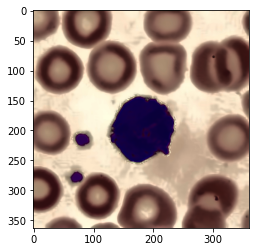

In [105]:
# Appliquer le filtre sur une Image test  
plt.imshow(cv2.cvtColor(EqualizerImg(path_dataset+'basophil/BA_100102.jpg'),  cv2.COLOR_BGR2RGB));

In [40]:
# filename='neutrophil/SNE_77275.jpg'
# img1 = filter_KmeansXYRGB(path+filename)
# img2 = filter_Kmeans2(path+filename)

# Fonction pour charger le dataset (.parquet)

In [57]:
def load_dataset(dataset_name):
    start = time.time()
    data_df = pd.read_parquet(dataset_name)
    end = time.time()
    load_time = round(end - start,3)
    
    return data_df, load_time

# Fonction pour les modeles

In [93]:
def modeling(dataset,model,display_results_list, param, cv):

    start = time.time()
    
    # Extraire les features et la variable cible
    
    target = dataset["type"]
    features = dataset.drop(["type"], axis = 1)
    
    # spliter les données
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, shuffle = True, random_state = 123)
    
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    

    if 'confusion_matrix' in display_results_list:
        cm_train = pd.crosstab (y_train, y_pred_train, rownames=['Reality'], colnames=['Prediction'])
        
    if 'classification_report' in display_results_list:
        CLASSIF_ON_TRAIN = classification_report(y_train, y_pred_train)
    
    if 'confusion_matrix' in display_results_list:
        cm_test = pd.crosstab (y_test, y_pred_test, rownames=['Reality'], colnames=['Prediction'])
        
    if 'classification_report' in display_results_list:
        CLASSIF_ON_TEST = classification_report(y_test, y_pred_test)

    if 'scores' in display_results_list:
        acc_train = round(model.score(X_train, y_train),2) # retourne l'accuracy du dataset d'entrainement
        acc_test = round(model.score(X_test, y_test),2) # retourne l'accuracy du dataset d'entrainement

    clf = RandomizedSearchCV(estimator = model,
                             param_distributions = param,
                             cv = cv,
                             # n_jobs = -1
                             n_iter = 5
                            )
        
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    acc_train_cv = clf.score(X_train, y_train) # retourne l'accuracy du dataset d'entrainement
    acc_test_cv = clf.score(X_test, y_test) # retourne l'accuracy du dataset d'entrainement
        
    acc_train_cv = round(acc_train,3)
    acc_test_cv = round(acc_test,2)
    
    Best_params = clf.best_params_
    Best_estimator =  clf.best_estimator_
        
    if str(model) == 'RandomForestClassifier()' :
        DF_cv_results = pd.DataFrame(clf.cv_results_)[['param_max_depth', 'param_n_estimators','param_criterion',
                                                           'param_bootstrap', 'param_max_leaf_nodes','param_max_features',
                                                           'mean_test_score', 'rank_test_score']]
    elif str(model) == "SVC()": 
        DF_cv_results = pd.DataFrame(clf.cv_results_)[['param_C', 'param_gamma','param_kernel','mean_test_score',
                                                           'rank_test_score']]
    
    end = time.time()
    duration = round(end - start,2)
    
    if str(model) == 'RandomForestClassifier()' :
        modele = 'RF'
    elif str(model) == 'SVC()' :
        modele = 'SVM'
        
    if 'confusion_matrix' in display_results_list: 
        return modele, acc_train, acc_test, cm_train, cm_test, duration
    
    elif 'classification_report' in display_results_list:
        return modele, acc_train, acc_test, CLASSIF_ON_TRAIN, CLASSIF_ON_TEST, duration
    
    else :
        return modele, acc_train, acc_test, duration , acc_train_cv, acc_test_cv
    

# Etude pour définir le rapport Taille/ Nombre d'images

Nous possédons un dataset de 17092 image réparties en 8 catégories. On va partir du principe que nous allons utiliser l'intégralité du dataset. 

Nous allons donc tenter de définir une taille d'image permettant d'utiliser l'intégralité du dataset sans déteriorer les résultats et en prenant en compte l'overfitting.

Par defaut nous utiliserons les images bruts sans filtre, c'est à dire en RGB

## Fonction pour ressortir les Resultats sous format d'un DataFrame

In [95]:
def Result_modeling (filter_liste, size_img, nb_img, models, param, cv) :
    '''
    Cette fonction permet de réetirer la fonction "modeling" du machine learning sur différents datasets, les datsets
    possèdes tous le même nombre d'images et la même taille des images mais chacun de ces datasets possède un filtre 
    différent. Ensuite resortir les résultats du machine learning sous forme d'un DataFrame
    
    '''
    # créer un dict où stocker le machine learning
    result_df = {'nbr_images': [],
                 'filter': [],
                 'taille' : [] ,
                 'load_time' : [],
                 'model': [],
                 'duration': [],
                 'accuracy_train': [],
                 'accuracy_test': [],
                 'methode' : [],
                 'accuracy_train_cv' :[],
                 'accuracy_test_cv' :[]
                         }
    
    for filter_img in filter_liste :

        # data_df, load_time = load_dataset(os.getcwd() + '\\' + 'dataset'+'_'+str(nb_img) + '_img__s_' + str(size_img) 
        #                                      +'x'+ str(size_img) + '__f_' + str(filter_img) + '.parquet')
    
        # on récupère le dataset à partir du nom standardisé pré-créé, dans le chemin path_data_prep
        data_df, load_time = load_dataset(path_data_prep + 'dataset'+'_'+str(nb_img) + '_img__s_' + str(size_img)+ 'x' + 
                                               str(size_img) + '__f_' + str(filter_img) + '.parquet')
        
        for model in models :
            modele, acc_train, acc_test, duration , acc_train_cv, acc_test_cv = modeling(data_df, model, ("scores"),param,cv) 
            
            # mettre à jour le dictionnaire avec les résultats à chaque itération 
            result_df['nbr_images'].append(str(nb_img))
            result_df['filter'].append(str(filter_img))
            result_df['taille'].append(str(size_img)+'x'+str(size_img))
            result_df['load_time'].append(load_time)
            result_df['model'].append(modele)
            result_df['duration'].append(duration)
            result_df['accuracy_train'].append(acc_train)
            result_df['accuracy_test'].append(acc_test)
            result_df['methode'].append('RandomizedSearchCV')
            result_df['accuracy_train_cv'].append(acc_train_cv)
            result_df['accuracy_test_cv'].append(acc_test_cv)

    df_results = pd.DataFrame.from_dict(result_df)
    return df_results
    

In [94]:
# utiliser du fin-tuning pour améliorer les résultats des modèles simples 'RandomForestClassifier()' et 'SVC()'  

# Paramètres du RF
param_rf = {'max_depth': [10,50, 100, 150,200, None], 
            'n_estimators':[10, 50, 100, 150, 200], 
            'criterion' : ['gini', 'entropy'],
            'bootstrap':[True, False],
            'max_leaf_nodes':[None,10, 50, 100, 150, 200],
            'max_features':['auto', 'sqrt']
           }

# Paramètres du SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'linear'],
            }

# All Taille 60x60 

In [92]:
# Exemple
"""Result_modeling(['rgb'], 30,"all", [RandomForestClassifier()],param_rf, cv=3)"""

,nbr_images,filter,taille,load_time,model,duration,accuracy_train,accuracy_test,methode,accuracy_train_cv,accuracy_test_cv
0,all,rgb,30x30,4.968,RF,1154.84,1.0,0.84,RandomizedSearchCV,100.0,84.0


In [28]:
# On selectionne le datset que nous voulons analyser on donnant ()
# Afficher les resultas dans un DataFrame
Resultats = Result_modeling(['rgb','hsv','lab','otsu','gray','canny','kmeans1','kmeans2', 'otsu_canny','threshold_color',
                             'threshold_color_g'], 60,"all", [RandomForestClassifier()])
Resultats 

,nbr_images,filter,taille,load_time,model,duration,accuracy_train,accuracy_test
0,all,rgb,60x60,13.763,RF,184.65,1.0,0.85
1,all,hsv,60x60,16.581,RF,163.34,1.0,0.85
2,all,lab,60x60,26.117,RF,207.73,1.0,0.82
3,all,otsu,60x60,7.415,RF,50.62,1.0,0.71
4,all,gray,60x60,5.758,RF,95.25,1.0,0.80
5,all,canny,60x60,5.001,RF,56.78,1.0,0.54
6,all,kmeans1,60x60,15.554,RF,153.55,1.0,0.83
7,all,kmeans2,60x60,16.732,RF,139.78,1.0,0.85
8,all,otsu_canny,60x60,6.146,RF,58.58,1.0,0.56
9,all,threshold_color,60x60,15.869,RF,142.67,1.0,0.78


# All Taille 45x45

In [48]:
Resultats = pd.concat([Resultats, Result_modeling(['rgb','hsv','lab','otsu','gray','canny','kmeans1','kmeans2', 'otsu_canny',
                                                'threshold_color','threshold_color_g'],45,"all", [RandomForestClassifier()])])
                             
Resultats

,nbr_images,filter,taille,load_time,model,duration,accuracy_train,accuracy_test
0,all,rgb,60x60,16.126,RF,231.51,1.0,0.85
1,all,hsv,60x60,17.607,RF,209.00,1.0,0.85
2,all,lab,60x60,18.576,RF,210.50,1.0,0.83
3,all,otsu,60x60,6.407,RF,52.83,1.0,0.71
4,all,gray,60x60,6.373,RF,103.22,1.0,0.80
5,all,canny,60x60,4.829,RF,59.45,1.0,0.55
6,all,kmeans1,60x60,15.195,RF,164.67,1.0,0.83
7,all,kmeans2,60x60,18.189,RF,153.61,1.0,0.85
8,all,otsu_canny,60x60,5.833,RF,57.73,1.0,0.55
9,all,threshold_color,60x60,15.977,RF,166.53,1.0,0.78


# All Taille 30x30

In [49]:
Resultats = pd.concat([Resultats, Result_modeling(['rgb'],30,"all", [RandomForestClassifier()])])
Resultats

,nbr_images,filter,taille,load_time,model,duration,accuracy_train,accuracy_test
0,all,rgb,60x60,16.126,RF,231.51,1.0,0.85
1,all,hsv,60x60,17.607,RF,209.00,1.0,0.85
2,all,lab,60x60,18.576,RF,210.50,1.0,0.83
3,all,otsu,60x60,6.407,RF,52.83,1.0,0.71
4,all,gray,60x60,6.373,RF,103.22,1.0,0.80
5,all,canny,60x60,4.829,RF,59.45,1.0,0.55
6,all,kmeans1,60x60,15.195,RF,164.67,1.0,0.83
7,all,kmeans2,60x60,18.189,RF,153.61,1.0,0.85
8,all,otsu_canny,60x60,5.833,RF,57.73,1.0,0.55
9,all,threshold_color,60x60,15.977,RF,166.53,1.0,0.78


# All Taille 20x20

In [50]:
Resultats = pd.concat([Resultats, Result_modeling(['rgb'],20,"all", [RandomForestClassifier()])])
Resultats

,nbr_images,filter,taille,load_time,model,duration,accuracy_train,accuracy_test
0,all,rgb,60x60,16.126,RF,231.51,1.0,0.85
1,all,hsv,60x60,17.607,RF,209.00,1.0,0.85
2,all,lab,60x60,18.576,RF,210.50,1.0,0.83
3,all,otsu,60x60,6.407,RF,52.83,1.0,0.71
4,all,gray,60x60,6.373,RF,103.22,1.0,0.80
5,all,canny,60x60,4.829,RF,59.45,1.0,0.55
6,all,kmeans1,60x60,15.195,RF,164.67,1.0,0.83
7,all,kmeans2,60x60,18.189,RF,153.61,1.0,0.85
8,all,otsu_canny,60x60,5.833,RF,57.73,1.0,0.55
9,all,threshold_color,60x60,15.977,RF,166.53,1.0,0.78


# All Taille 10x10

In [51]:
Resultats = pd.concat([Resultats, Result_modeling(['rgb'],10,"all", [RandomForestClassifier()])])
Resultats

,nbr_images,filter,taille,load_time,model,duration,accuracy_train,accuracy_test
0,all,rgb,60x60,16.126,RF,231.51,1.0,0.85
1,all,hsv,60x60,17.607,RF,209.00,1.0,0.85
2,all,lab,60x60,18.576,RF,210.50,1.0,0.83
3,all,otsu,60x60,6.407,RF,52.83,1.0,0.71
4,all,gray,60x60,6.373,RF,103.22,1.0,0.80
5,all,canny,60x60,4.829,RF,59.45,1.0,0.55
6,all,kmeans1,60x60,15.195,RF,164.67,1.0,0.83
7,all,kmeans2,60x60,18.189,RF,153.61,1.0,0.85
8,all,otsu_canny,60x60,5.833,RF,57.73,1.0,0.55
9,all,threshold_color,60x60,15.977,RF,166.53,1.0,0.78


In [20]:
# ecrire les resultats dans un fichier Excel 
# path_output = "C:/Users/HP/Desktop/Projets Data Sciences/20211121-Projet_Deep Learning_Blood_Cell/5.Insights/"
# Paul à Said : J'ai ajouté ce chemin au fichier path.csv sous le paramètre path_analysis

Resultats.to_excel(path_analysis + 'Resultats_MachineLearning_RF.xlsx', index=False)

In [21]:
Resultats=pd.read_excel(path_analysis + 'Resultats_MachineLearning_RF.xlsx')
Resultats

,nbr_images,filter,taille,load_time,model,duration,accuracy_train,accuracy_test
0,all,rgb,60x60,16.126,RF,231.51,1,0.85
1,all,hsv,60x60,17.607,RF,209.00,1,0.85
2,all,lab,60x60,18.576,RF,210.50,1,0.83
3,all,otsu,60x60,6.407,RF,52.83,1,0.71
4,all,gray,60x60,6.373,RF,103.22,1,0.80
5,all,canny,60x60,4.829,RF,59.45,1,0.55
6,all,kmeans1,60x60,15.195,RF,164.67,1,0.83
7,all,kmeans2,60x60,18.189,RF,153.61,1,0.85
8,all,otsu_canny,60x60,5.833,RF,57.73,1,0.55
9,all,threshold_color,60x60,15.977,RF,166.53,1,0.78
